In [1]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
import math
from paq2py import *
from utils import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

%matplotlib notebook


In [2]:
csv_path = '/home/jamesrowland/Desktop/davids_axons/Values.csv'
paq_path = '/home/jamesrowland/Desktop/davids_axons/2019-03-18_CBCB1337.2d_t-015.paq'

In [3]:
#use fiji reader from utils to build array
raw = read_fiji(csv_path)
data = dfof(raw)

#read paq file using lloyds code
paq = paq_read(paq_path)
rate = paq['rate']

In [4]:
clock_idx = paq['chan_names'].index('frame_clock')
#voltage from the frame clock channel
clock_voltage = paq['data'][clock_idx, :]

#digitise frame clock, two clocks should not occur less than 10ms apart or more than 100ms apart
frame_clock = digitise_trigger(clock_voltage, min_time = 0.01*paq['rate'], max_time = 0.1*paq['rate'])

In [5]:
#name of the stimulus channel
stim_idx = paq['chan_names'].index('clean_stim')
stim_volts = paq['data'][stim_idx, :]

#stims should not occur within 1ms of each other
stim_times = threshold_detect(stim_volts, 1)

<IPython.core.display.Javascript object>


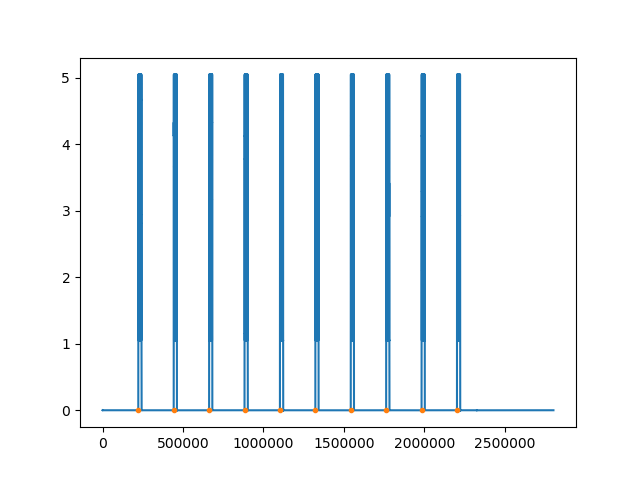

In [6]:
plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.zeros(len(stim_times)), '.')
plt.show()
#plt.xlim((660000, 665000))

In [7]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim > 0)
    
    stim_start_frames.append(stim_start_frame)

stim_start_frames = np.array(stim_start_frames)


In [10]:
pre_frames = 100
post_frames = 150

#all observations before stimulus onset
pre_obs = []
#all observations post stimulus onset
post_obs = []

#3d array of trial binned data
trials = []


for stim in stim_start_frames:
  
    trial = data[stim-pre_frames:stim+post_frames]
    trials.append(trial)
    
    pre_stim  = data[stim-pre_frames:stim]
    post_stim = data[stim:stim+post_frames]

    [pre_obs.append(ob) for ob in pre_stim]
    [post_obs.append(ob) for ob in post_stim]
    
trials = np.array(trials)
sta = np.mean(trials, 0)        
    
t_test = stats.ttest_ind(pre_obs, post_obs)   
t_test

Ttest_indResult(statistic=-23.97065265175059, pvalue=1.843840726616472e-114)

<IPython.core.display.Javascript object>


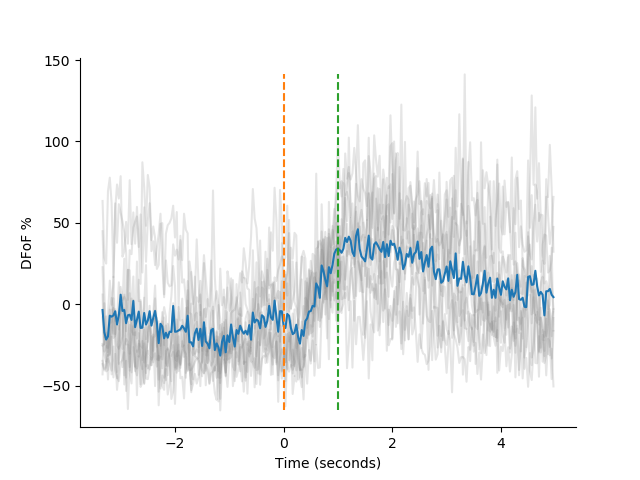

In [28]:
frame_rate = 30
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate


plt.figure()
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in trials]
plt.plot(x_axis, sta)
plt.plot([0] * 100, np.linspace(np.min(trials), np.max(trials), 100), '--')
plt.plot([1] * 100, np.linspace(np.min(trials), np.max(trials), 100), '--')
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF %')

sns.despine()
plt.show()
plt.savefig("claustrum_sound.pdf")